<a href="https://colab.research.google.com/github/erickraemer/dcgan-human-faces/blob/main/Human_Face_Image_Synthesis_by_using_DCGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Face Image Synthesis by using Deep Convolutional Generative Adversarial Networks

**Human Face Image Synthesis by using Deep Convolutional Generative Adversarial Networks** \

Implemention based on the "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" paper by Radford et. al.

**Instructions:**\
Execute the cells below to:
1. Download the dataset into the current session
2. Train the model with the dataset for 4 epochs
3. Generate a set of images from the trained model

Press STRG + F9 to run all code cells in order.\
Step 3 can be rerun without step 1 & 2 to generate more images.

## 1. Download the dataset

In [1]:
!pip install wget
from typing import Optional
import IPython
from IPython.display import display, DisplayHandle
import os
import sys
import wget
import zipfile
from torchvision import datasets

stdout: Optional[DisplayHandle] = None
current_file: str = ""

def bar_progress(current: int, total: int, width: int = 80) -> None:
    """
    Prints the download status
    :param current: current MbB
    :param total: total MB to download
    :param width: bar width (unused)
    """

    s = f"Downloading {current_file}: {round(current / total * 100, 1)}% [{round(current/1e+6, 1)} / {round(total/1e+6, 1)}] MB"
    stdout.update(IPython.display.Pretty(s))

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

# set dataset path
dataset_folder = "data/celeba"
os.makedirs(dataset_folder, exist_ok=True)

print("Downloading Celeba dataset ...")
for file in file_list:
    p = f"{dataset_folder}/{file}"
    if not os.path.exists(p):
        stdout = display(IPython.display.Pretty('...'), display_id=True)
        current_file = file
        wget.download(f"{base_url}/{file}", p, bar=bar_progress)

print("\nExtracting dataset ...")
with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as zip:
    zip.extractall(dataset_folder)

# verify dataset
try:
    datasets.CelebA(root="data")
    print("Dataset downloaded and extracted successfully")
except:
    raise RuntimeError("Download or extraction of the celeba dataset failed!")


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=a6e1e8602bc8850f132a1b4b875ae91f651b4f965affe8ff1850b9c44f712a5e
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget



Extracting dataset ...
Dataset downloaded and extracted successfully


## 2. Create and train the model

In [2]:
import abc
import typing

import torch as pt
import os
import IPython
from torch import nn, optim
from typing import Optional, Final
import torchvision.datasets as dset
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets


class Base(nn.Module):
    """
    Abstract base class for the generator and discriminator
    """

    # hyperparameters
    GEN_OUT_CHANNEL = 3  # generator channel output
    STRIDE: int = 2  # stride to use for the convolution
    FEATURES: int = 64  # finale image size
    KERNEL_SIZE: int = 4  # kernel size to use for the convolution
    PADDING: int = 1  # padding to use for the convolution
    N_CONV: int = 4  # amount of convolution layers
    W_INIT_MEAN: float = 0  # weight initialization mean
    W_INIT_STD: float = 0.02  # weight initialization std
    L_RELU_N_SLOPE: float = 0.2  # leaky relu slope
    BIAS: bool = False  # use bias?

    def __init__(self):
        super().__init__()
        # stores the network architecture
        self._network_stack: nn.Sequential = nn.Sequential()

    @abc.abstractmethod
    def _get_hidden_layer_activation(self) -> nn.modules.activation.Module:
        """
        Override to define the correct activation function to be used for the hidden layers
        """
        raise NotImplemented()

    @staticmethod
    @abc.abstractmethod
    def _get_conv_module(*args, **kwargs) -> nn.modules.Module:
        """
        Override to define the correct torch module to be used for the hidden layers
        """
        raise NotImplemented()

    def _get_conv2d(self, c_in: int, c_out: int, stride: Optional[int] = None,
                    padding: Optional[int] = None) -> nn.modules.Module:
        """
        Returns an initialized module defined by _get_conv_module
        with the hyperparameters from the Base class.
        :param c_in: input channels
        :param c_out: output channels
        :param stride: stride
        :param padding: padding
        :return: initialized torch module
        """
        # use default parameter
        if stride is None:
            stride: int = self.STRIDE

        # use default parameter
        if padding is None:
            padding: int = self.PADDING

        # create convolution layer
        conv2d = self._get_conv_module(
            in_channels=c_in,
            out_channels=c_out,
            kernel_size=self.KERNEL_SIZE,
            stride=stride,
            padding=padding,
            bias=self.BIAS,
        )

        # initialize weights with a normal distribution
        nn.init.normal_(conv2d.weight, self.W_INIT_MEAN, self.W_INIT_STD)
        return conv2d

    def _hidden_layer_gen(self, reverse: bool = False) -> typing.Generator:
        """
        Returns a generator to create the hidden convolution layers.
        Channel in size is calculated by: Base.FEATURES * 2 ** Base.N_CONV
        Layer amount is defined by Base.N_CONV
        Channel out size is defined by Base.GEN_OUT_CHANNEL
        :param reverse: False = from big to small, True = from small to big
        :return: the generator
        """
        support_index = (1, self.N_CONV, 1) if reverse else (self.N_CONV-1, 0, -1)

        for i in range(*support_index):
            j: int = int(self.FEATURES * 2 ** i)
            k: int = j // 2

            if reverse:
                j, k = k, j

            yield self._get_conv2d(j, k)

             # prepare batch norm
            bn = nn.BatchNorm2d(k)
            nn.init.normal_(bn.weight.data, 1.0, 0.02)
            nn.init.constant_(bn.bias.data, 0)
            yield bn

            yield self._get_hidden_layer_activation()

    def forward(self, x: pt.Tensor):
        """
        Forward propagation of the network
        :param x: data
        :return: output of the network
        """
        return self._network_stack(x)

class Generator(Base):
    """
    Generator class. The Generator is repsonsible to generate images
    learned from the dataset
    """

    INPUT_SIZE: int = 100  # generator noise input size

    def __init__(self):
        super().__init__()

        # build network
        self._network_stack = nn.Sequential(
            # input layer
            self._get_conv2d(self.INPUT_SIZE, self.FEATURES * 2 ** (self.N_CONV-1), stride=1, padding=0),
            nn.BatchNorm2d(self.FEATURES * 2 ** (self.N_CONV-1)),
            self._get_hidden_layer_activation(),

            # hidden layers
            *list(self._hidden_layer_gen()),

            # output layer
            self._get_conv2d(self.FEATURES, self.GEN_OUT_CHANNEL),
            nn.Tanh()
        )

    # override
    def _get_hidden_layer_activation(self) -> nn.modules.activation.Module:
        return nn.ReLU(True)

    # override
    @staticmethod
    def _get_conv_module(*args, **kwargs) -> nn.modules.Module:
        return nn.ConvTranspose2d(*args, **kwargs)


class Discriminator(Base):
    """
    Discriminator class. The Disciminator is responsable to detect artifical
    generated images
    """

    def __init__(self):
        super().__init__()

        # build network
        self._network_stack = nn.Sequential(
            # input layer
            self._get_conv2d(self.GEN_OUT_CHANNEL, self.FEATURES),
            # no batch norm in the first layer
            nn.LeakyReLU(self.L_RELU_N_SLOPE, True),

            # hidden layers
            *list(self._hidden_layer_gen(reverse=True)),

            # output layer
            self._get_conv2d(self.FEATURES * 2 ** (self.N_CONV-1), 1, stride=1, padding=0),
            nn.Sigmoid()
        )

    # override
    def _get_hidden_layer_activation(self) -> nn.modules.activation.Module:
        return nn.LeakyReLU(self.L_RELU_N_SLOPE, True)

    # override
    @staticmethod
    def _get_conv_module(*args, **kwargs) -> nn.modules.Module:
        return nn.Conv2d(*args, **kwargs)


def trim_digits(f: float, n: int = 2) -> str:
    """
    Trims the input number to the last n non-zero digits
    :param f: a float number
    :param n: last n non-zero digits to keep
    :return: trimmed number as a string
    """

    s = str(f)
    e = s.find('e')
    for i in range(len(s)):
        if s[i] == '.':
            return s[:min(i + n, len(s))] + s[e:]
    return s


def get_celeba() -> datasets.CelebA:
    """
    Returns the Celeba dataset. Will fail if it is not
    donwloaded
    :return: celeba dataset
    """

    return datasets.CelebA(
        root="data",
        split="all",
        transform=transforms.Compose([
            transforms.Resize((64,64)),
            # transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    )


dev: str = "cuda" if pt.cuda.is_available() else "cpu"
print(f"Using device: {dev}")

# hyperparameter
beta: float = 0.5  # Adam scaler
adam_decay_rate: float = 0.999
learning_rate: float = 0.0002
batch_size: int = 128
n_epochs: int = 5
noise_mean: float = 0.  # mean for generating the input noise
noise_std: float = 0.2  # std for generating the input noise

# try to find the Celeba dataset
try:
    dataset = get_celeba()
    print("Found dataset")
except RuntimeError:
    raise RuntimeError("Celeba dataset could not be found, please download it first!")

# prepare dataloader
data_loader = DataLoader(dataset=dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)

# prepare generator
generator = Generator().to(dev)
generator.train(True)
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta, adam_decay_rate))

# prepare discriminator
discriminator = Discriminator().to(dev)
discriminator.train(True)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta, adam_decay_rate))

# prepare loss function and labels
bce: Final[nn.BCELoss] = nn.BCELoss()
fake_labels: Final[pt.Tensor] = pt.zeros((batch_size,), device=dev, requires_grad=False)
real_labels: Final[pt.Tensor] = pt.ones_like(fake_labels, device=dev, requires_grad=False)

# training loop
print("Starting training loop")
print(f"Trainig for {n_epochs} epochs with a learning rate of {learning_rate}:")

info_out = display(IPython.display.Pretty('...'), display_id=True)
for epoch in range(n_epochs):
    generator.train()
    discriminator.train()
    real_img_batch: pt.Tensor  # type hint
    for i, (real_img_batch, _) in enumerate(data_loader):
        # move training data to cuda if available
        real_img_batch = real_img_batch.to(dev, non_blocking=True)
        b_size = len(real_img_batch)

        # generate fake images
        discriminator.zero_grad()
        noise = pt.normal(mean=noise_mean, std=noise_std, size=(b_size, Generator.INPUT_SIZE, 1, 1), device=dev)
        fake_image_batch = generator(noise)

        # calculate fake image loss
        fake_img_prediction = discriminator(fake_image_batch.detach()).squeeze()
        d_loss_fake = bce(fake_img_prediction, fake_labels[:b_size])
        d_loss_fake.backward()

        # calculate real image loss
        real_img_prediction = discriminator(real_img_batch).squeeze()
        d_loss_real = bce(real_img_prediction, real_labels[:b_size])
        d_loss_real.backward()  # gradients add up internally

        # calculate discriminator loss
        d_loss = d_loss_fake + d_loss_real

        # update discriminator weights
        optimizer_d.step()

        # calculate generator loss
        generator.zero_grad()
        fake_img_prediction = discriminator(fake_image_batch).squeeze()
        g_loss = bce(fake_img_prediction, real_labels[:b_size])

        # calculate generator gradient and update weights
        g_loss.backward()
        optimizer_g.step()

        info = f"Epoch: {epoch} | Batch {i}/{len(data_loader)} | G_Loss: {trim_digits(g_loss.item())} | D_Loss: {trim_digits(d_loss.item())}"
        info_out.update(IPython.display.Pretty(info))

info_out.update(IPython.display.Pretty("Training finished"))

# save the generator
os.makedirs("models", exist_ok=True)
path = "models/generator.pth"
pt.save(generator, path)
print(f"\nSaved model to \"{path}\"")


Using device: cuda
Found dataset
Starting training loop
Trainig for 5 epochs with a learning rate of 0.0002:


Training finished


Saved model to "models/generator.pth"


## 3. Generate a set of images from the trained model

Using device: cuda


<ipython-input-6-4c992563e8ba>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator = pt.load("models/generator.pth").to(dev)


<Figure size 640x480 with 0 Axes>

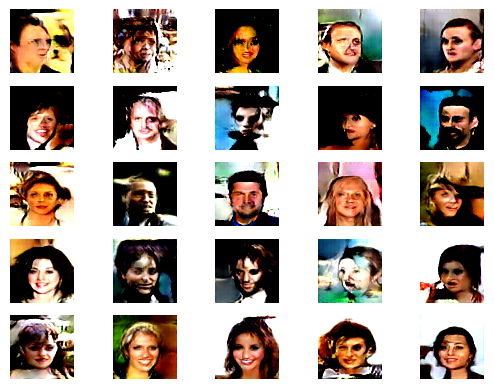

In [6]:
import os
import torch as pt
from typing import Final
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# prefer cuda if available
dev: str = "cuda" if pt.cuda.is_available() else "cpu"
print(f"Using device: {dev}")

# size of the square of images to generate
# e.g. 5 will generate a square of 5 by 5 images
generate_n_images = 5

# load model
if not os.path.isfile("models/generator.pth"):
    raise RuntimeError("Model could not be found, please train the model first!")

generator = pt.load("models/generator.pth").to(dev)
generator.eval()

# generate images
noise_mean: float = 0.
noise_std: float = 0.2
with pt.no_grad():
    noise = pt.normal(mean=noise_mean, std=noise_std, size=(generate_n_images**2, generator.INPUT_SIZE, 1, 1), device=dev)
    images = pt.clip(generator(noise) + 0.5, min=0., max=1.)

# plot images
plt.figure()
f, ax = plt.subplots(generate_n_images, generate_n_images)
for i in range(generate_n_images):
    for j in range(generate_n_images):
        ax[i][j].set_axis_off()
        img = to_pil_image(images[i*generate_n_images+j].cpu())
        ax[i][j].imshow(img)
plt.show()
